In [2]:
import os
import sys
sys.path.append(os.path.abspath(r'/Users/fuchuenli/Desktop/Data Science /Year 2/Trimester 2/COMP SCI 7097/GP-SHAP/Shapley Prior'))
sys.path.append(os.path.abspath(r'/Users/fuchuenli/Desktop/Data Science /Year 2/Trimester 2/COMP SCI 7097/RKHS-SHAP'))

In [3]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import pandas as pd
import seaborn as sns

from gpytorch.kernels import RBFKernel
from sklearn.datasets import load_diabetes
import matplotlib.pylab as plt
from gpytorch.lazy import lazify

from src.gp_model.VariationalGPRegression import VariationalGPRegression
from src.explanation_algorithms.BayesGPSHAP import BayesGPSHAP
from src.predictive_explanation.ShapleyPrior import ShapleyPrior
from src.utils.visualisation import summary_plot
from src.predictive_explanation.ShapleyKernel import ShapleyKernel
from sklearn.datasets import fetch_california_housing
from math import comb

import fastshap
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os, sys, pickle, warnings, torch, shap

import numpy as np
from experiments.BananaShapley.banana_distribution import Banana2d
from experiments.BananaShapley.gshap_banana import Observation2dBanana

warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, pairwise_distances, r2_score
import copy

In [41]:
n = 1000
v = 10
b = 0.01
iterations = 10
result = []

banana2d = Banana2d(n=n, v=v, b=b, noise=0, outlier_quantile=2.)

# Scaled the output so that can we compare accuracy across
scale = 1
y = torch.Tensor(banana2d.y/scale)
X = torch.Tensor(banana2d.X)
d = X.shape[1]

compute_mh = lambda X: np.array([np.median(pairwise_distances(X[:, [i]])) for i in range(X.shape[1])])
lengthscale = torch.tensor(compute_mh(X)).float()
lengthscale[1] *= 1
print("Lengthscale:", lengthscale)

# True OSVs:
phi1 = banana2d.phi_1/scale
phi2 = banana2d.phi_2/scale
PHI = np.array([phi1, phi2]).T

# True ISVs:
phi1_I = banana2d.phi_1_I
phi2_I = banana2d.phi_2_I
PHI_I = np.array([phi1_I, phi2_I]).T

Lengthscale: tensor([3.0637, 0.9047])


In [42]:
cutting_points = 800

X_train = X[:cutting_points]
y_train = y[:cutting_points]
X_test = X[cutting_points:]
y_test = y[cutting_points:]

PHI_train = PHI[:cutting_points]
PHI_test = PHI[cutting_points:]

In [43]:
kernel = RBFKernel
gp_regression = VariationalGPRegression(
    X_train, y_train, kernel=kernel, num_inducing_points=200, batch_size=128)

gp_regression.fit(learning_rate=1e-2,
                  training_iteration=300)

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

## Fast-SHAP

In [8]:
import torch
import torch.nn as nn
from fastshap.utils import MaskLayer1d
from fastshap import Surrogate, KLDivLoss
from fastshap import FastSHAP

In [9]:
fastshap_training_start = time.time()

In [10]:
surr = nn.Sequential(
    MaskLayer1d(value=0, append=True),
    nn.Linear(2 * d, 128),
    nn.ELU(inplace=True),
    nn.Linear(128, 128),
    nn.ELU(inplace=True),
    nn.Linear(128, 1)
)

surrogate = Surrogate(surr, d)

def original_model(x):
    return gp_regression.predict(x).mean.detach().reshape(-1, 1).float()

surrogate.train_original_model(
    X_train,
    X_test,
    original_model,
    batch_size=64,
    max_epochs=100,
    loss_fn=nn.MSELoss(),
    validation_samples=10,
    validation_batch_size=10000,
    verbose=True
)

----- Epoch = 1 -----
Val loss = 0.5941

New best epoch, loss = 0.5941

----- Epoch = 2 -----
Val loss = 0.4565

New best epoch, loss = 0.4565

----- Epoch = 3 -----
Val loss = 0.4540

New best epoch, loss = 0.4540

----- Epoch = 4 -----
Val loss = 0.4754

----- Epoch = 5 -----
Val loss = 0.4537

New best epoch, loss = 0.4537

----- Epoch = 6 -----
Val loss = 0.4435

New best epoch, loss = 0.4435

----- Epoch = 7 -----
Val loss = 0.4542

----- Epoch = 8 -----
Val loss = 0.4423

New best epoch, loss = 0.4423

----- Epoch = 9 -----
Val loss = 0.4407

New best epoch, loss = 0.4407

----- Epoch = 10 -----
Val loss = 0.4481

----- Epoch = 11 -----
Val loss = 0.4390

New best epoch, loss = 0.4390

----- Epoch = 12 -----
Val loss = 0.4485

----- Epoch = 13 -----
Val loss = 0.4382

New best epoch, loss = 0.4382

----- Epoch = 14 -----
Val loss = 0.4368

New best epoch, loss = 0.4368

----- Epoch = 15 -----
Val loss = 0.4348

New best epoch, loss = 0.4348

----- Epoch = 16 -----
Val loss = 0.43

In [11]:
explainer = nn.Sequential(
    nn.Linear(d, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2 * d))

# Set up FastSHAP object
fastshap = FastSHAP(explainer, surrogate, normalization='additive')

# Train
fastshap.train(
    X_train,
    X_test,
    batch_size=32,
    num_samples=32,
    max_epochs=200,
    validation_samples=128,
    verbose=True)

----- Epoch = 1 -----
Val loss = 0.434067

New best epoch, loss = 0.434067

----- Epoch = 2 -----
Val loss = 0.354913

New best epoch, loss = 0.354913

----- Epoch = 3 -----
Val loss = 0.280279

New best epoch, loss = 0.280279

----- Epoch = 4 -----
Val loss = 0.214861

New best epoch, loss = 0.214861

----- Epoch = 5 -----
Val loss = 0.154887

New best epoch, loss = 0.154887

----- Epoch = 6 -----
Val loss = 0.106269

New best epoch, loss = 0.106269

----- Epoch = 7 -----
Val loss = 0.070018

New best epoch, loss = 0.070018

----- Epoch = 8 -----
Val loss = 0.045128

New best epoch, loss = 0.045128

----- Epoch = 9 -----
Val loss = 0.031002

New best epoch, loss = 0.031002

----- Epoch = 10 -----
Val loss = 0.023360

New best epoch, loss = 0.023360

----- Epoch = 11 -----
Val loss = 0.019350

New best epoch, loss = 0.019350

----- Epoch = 12 -----
Val loss = 0.017053

New best epoch, loss = 0.017053

----- Epoch = 13 -----
Val loss = 0.015031

New best epoch, loss = 0.015031

----- Ep

In [12]:
fastshap_training_end = time.time()

In [13]:
fastshap_training_time = fastshap_training_end - fastshap_training_start

In [14]:
fastshap_implementation_start = time.time()

In [15]:
# fastshap predictions
fastshap_preds = [fastshap.shap_values(X_test[i:i+1])[0].mean(axis=1) for i in range(X.shape[0] - 300)]
fastshap_preds = torch.tensor(fastshap_preds).t()

In [16]:
fastshap_implementation_end = time.time()

In [17]:
fast_shap_implementation_time = fastshap_implementation_end - fastshap_implementation_start

## Shapley Prior

In [18]:
bayesgpshap = BayesGPSHAP(train_X=X, kernel=RBFKernel(), gp_model=gp_regression,
                          include_likelihood_noise_for_explanation=False, scale=scale)

In [19]:
bayesgpshap.run_bayesSHAP(X=X, num_coalitions=2**d)
explanations = bayesgpshap.mean_shapley_values

100%|██████████| 3/3 [00:00<00:00, 438.46it/s]


In [20]:
shapley_prior_training_start = time.time()

In [21]:
target = explanations.t().reshape(-1, 1)
shapley_kernel = ShapleyKernel(
    train_X=X, kernel=RBFKernel(), lengthscales=gp_regression.lengthscale, 
    inducing_points=gp_regression.inducing_points,
    num_coalitions=2**(d-1), sampling_method="subsampling", verbose=False
)

target_train = target[:cutting_points*d]

optim = torch.optim.Adam(shapley_kernel.parameters(), lr=1e-3)
def loss_function(pred, true):
    return torch.mean((true - pred) **2)

for _ in range(150):
    optim.zero_grad()
    Psi = shapley_kernel(X)
    K = torch.einsum("ijk,lmn->imkn", Psi, Psi.transpose(0, 1))
    K = K.permute(2, 0, 3, 1).resize(len(target), len(target))
    K_train = K[:cutting_points*d, :cutting_points*d]
    prediction = K_train @ lazify(K_train).add_diag(shapley_kernel.krr_regularisation).inv_matmul(target_train)
    loss = loss_function(prediction, target_train)
    print(loss)
    loss.backward()
    optim.step()


tensor(0.4467, grad_fn=<MeanBackward0>)
tensor(0.4463, grad_fn=<MeanBackward0>)
tensor(0.4458, grad_fn=<MeanBackward0>)
tensor(0.4454, grad_fn=<MeanBackward0>)
tensor(0.4449, grad_fn=<MeanBackward0>)
tensor(0.4444, grad_fn=<MeanBackward0>)
tensor(0.4440, grad_fn=<MeanBackward0>)
tensor(0.4435, grad_fn=<MeanBackward0>)
tensor(0.4430, grad_fn=<MeanBackward0>)
tensor(0.4425, grad_fn=<MeanBackward0>)
tensor(0.4421, grad_fn=<MeanBackward0>)
tensor(0.4416, grad_fn=<MeanBackward0>)
tensor(0.4411, grad_fn=<MeanBackward0>)
tensor(0.4406, grad_fn=<MeanBackward0>)
tensor(0.4400, grad_fn=<MeanBackward0>)
tensor(0.4395, grad_fn=<MeanBackward0>)
tensor(0.4390, grad_fn=<MeanBackward0>)
tensor(0.4385, grad_fn=<MeanBackward0>)
tensor(0.4379, grad_fn=<MeanBackward0>)
tensor(0.4374, grad_fn=<MeanBackward0>)
tensor(0.4368, grad_fn=<MeanBackward0>)
tensor(0.4363, grad_fn=<MeanBackward0>)
tensor(0.4357, grad_fn=<MeanBackward0>)
tensor(0.4351, grad_fn=<MeanBackward0>)
tensor(0.4345, grad_fn=<MeanBackward0>)


In [22]:
shapley_prior_training_end = time.time()

In [23]:
shapley_prior_training_time = shapley_prior_training_end - shapley_prior_training_start

In [24]:
shapley_prior_implementation_start = time.time()

In [25]:
Psi = shapley_kernel(X)
K = torch.einsum("ijk,lmn->imkn", Psi, Psi.transpose(0, 1))
K = K.permute(2, 0, 3, 1).resize(len(target), len(target))

K_train = K[:cutting_points*d, :cutting_points*d]
K_test_train = K[cutting_points*d:, :cutting_points*d]

train_target = target[:cutting_points*d]
test_target = target[cutting_points*d:]

pred = K_test_train @ lazify(K_train).add_diag(shapley_kernel.krr_regularisation).inv_matmul(train_target)

In [26]:
pred = pred.reshape((-1, 2)).detach().numpy()

In [27]:
shapley_prior_implementation_end = time.time()

In [28]:
shapley_prior_implementation_time = shapley_prior_implementation_end - shapley_prior_implementation_start

## KernelSHAP

In [44]:
import shap
import numpy as np

# Assume this is your custom model class
class CustomModel:
    def predict_custom(self, data):
        # Your prediction logic here
        pred = []
        for i in range(data.shape[0]):
            pred.append(gp_regression.predict(torch.Tensor(data[i]).reshape((1,d))).loc.item())
        return np.array(pred)

# Create an instance of your model
model = CustomModel()

# Define a wrapper function for the model's prediction
def model_predict(data):
    return model.predict_custom(data)

# # Say you have some training data X_train and you want to explain predictions on X_test
# background_data = X_train
# explainer = shap.KernelExplainer(model_predict, X.numpy())

# # Compute SHAP values for a specific instance (or multiple instances)
# shap_values = explainer.shap_values(X_test.numpy())

# # Now you can visualize or analyze the SHAP values as needed


In [45]:
gshap_implementation_start_time = time.time()

In [46]:
ogshap = Observation2dBanana(model_predict, X_test.numpy())
ophi1, ophi2 = ogshap.fit(X_test, num_samples=X_test.shape[0])    
OPHI = np.array([ophi1,ophi2]).T

100%|██████████| 178/178 [00:32<00:00,  5.48it/s]


In [47]:
gshap_implementation_end_time = time.time()

In [48]:
gshap_implementation_time = gshap_implementation_end_time - gshap_implementation_start_time

## Evaluation

In [51]:
results = pd.DataFrame({"SHAP": ["GSHAP", "FastSHAP", "ShapleyPrior"], "Training Time":[0, fastshap_training_time, shapley_prior_training_time], "Implementation Time": [gshap_implementation_time, fast_shap_implementation_time, shapley_prior_implementation_time]})
results["Total Time"] = results["Training Time"] + results["Implementation Time"]
results

,SHAP,Training Time,Implementation Time,Total Time
0,GSHAP,0.000000,34.349118,34.349118
1,FastSHAP,9.027937,0.128644,9.156581
2,ShapleyPrior,7.636084,0.111606,7.747690


Text(0, 0.5, 'Time(s)')

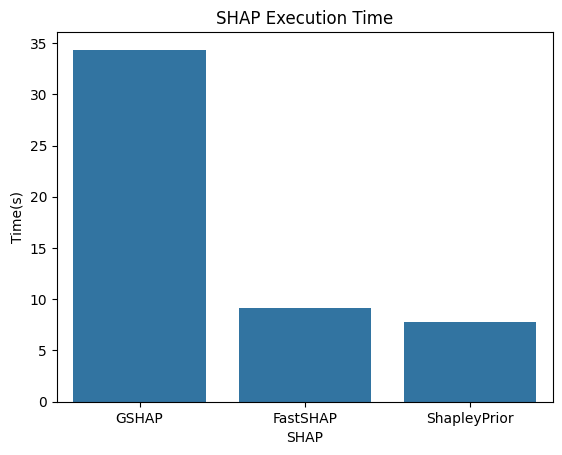

In [52]:
sns.barplot(data=results, x="SHAP", y="Total Time")
plt.title("SHAP Execution Time")
plt.xlabel("SHAP")
plt.ylabel("Time(s)")

In [78]:
import os
import sys
sys.path.append(os.path.abspath(r'/Users/fuchuenli/Desktop/Data Science /Year 2/Trimester 2/COMP SCI 7097/GP-SHAP/Shapley Prior'))
sys.path.append(os.path.abspath(r'/Users/fuchuenli/Desktop/Data Science /Year 2/Trimester 2/COMP SCI 7097/RKHS-SHAP'))

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import pandas as pd
import seaborn as sns

from gpytorch.kernels import RBFKernel
from sklearn.datasets import load_diabetes
import matplotlib.pylab as plt
from gpytorch.lazy import lazify

from src.gp_model.VariationalGPRegression import VariationalGPRegression
from src.explanation_algorithms.BayesGPSHAP import BayesGPSHAP
from src.predictive_explanation.ShapleyPrior import ShapleyPrior
from src.utils.visualisation import summary_plot
from src.predictive_explanation.ShapleyKernel import ShapleyKernel
from sklearn.datasets import fetch_california_housing
from math import comb

import fastshap
import time

import os, sys, pickle, warnings, torch, shap

import numpy as np
from experiments.BananaShapley.banana_distribution import Banana2d
from experiments.BananaShapley.gshap_banana import Observation2dBanana

warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, pairwise_distances, r2_score
import copy

import torch
import torch.nn as nn
from fastshap.utils import MaskLayer1d
from fastshap import Surrogate, KLDivLoss
from fastshap import FastSHAP

import shap
import numpy as np

if __name__ == "__main__":

    n_ls = [1020, 1110]
    v = 10
    b = 0.01
    iterations = 10
    results = {"SHAP": [], "#Sample": [], "Training Time": [], "Implementation Time": []}
    for n in n_ls:
        banana2d = Banana2d(n=n, v=v, b=b, noise=0)

        # Scaled the output so that can we compare accuracy across
        scale = 1
        y = torch.Tensor(banana2d.y/scale)
        X = torch.Tensor(banana2d.X)
        d = X.shape[1]

        compute_mh = lambda X: np.array([np.median(pairwise_distances(X[:, [i]])) for i in range(X.shape[1])])
        lengthscale = torch.tensor(compute_mh(X)).float()
        lengthscale[1] *= 1
        print("Lengthscale:", lengthscale)

        # True OSVs:
        phi1 = banana2d.phi_1/scale
        phi2 = banana2d.phi_2/scale
        PHI = np.array([phi1, phi2]).T

        # True ISVs:
        phi1_I = banana2d.phi_1_I
        phi2_I = banana2d.phi_2_I
        PHI_I = np.array([phi1_I, phi2_I]).T

        cutting_points = 1000

        X_train = X[:cutting_points]
        y_train = y[:cutting_points]
        X_test = X[cutting_points:]
        y_test = y[cutting_points:]

        PHI_train = PHI[:cutting_points]
        PHI_test = PHI[cutting_points:]

        kernel = RBFKernel
        gp_regression = VariationalGPRegression(
            X_train, y_train, kernel=kernel, num_inducing_points=200, batch_size=128)

        gp_regression.fit(learning_rate=1e-2,
                        training_iteration=300)
        
        fastshap_training_start = time.time()

        surr = nn.Sequential(
        MaskLayer1d(value=0, append=True),
        nn.Linear(2 * d, 128),
        nn.ELU(inplace=True),
        nn.Linear(128, 128),
        nn.ELU(inplace=True),
        nn.Linear(128, 1)
        )

        surrogate = Surrogate(surr, d)

        def original_model(x):
            return gp_regression.predict(x).mean.detach().reshape(-1, 1).float()

        surrogate.train_original_model(
            X_train,
            X_test,
            original_model,
            batch_size=64,
            max_epochs=100,
            loss_fn=nn.MSELoss(),
            validation_samples=10,
            validation_batch_size=10000,
            verbose=True
        )

        explainer = nn.Sequential(
        nn.Linear(d, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 2 * d))

        # Set up FastSHAP object
        fastshap = FastSHAP(explainer, surrogate, normalization='additive')

        # Train
        fastshap.train(
            X_train,
            X_test,
            batch_size=32,
            num_samples=32,
            max_epochs=200,
            validation_samples=128,
            verbose=True)
        
        fastshap_training_end = time.time()
        fastshap_training_time = fastshap_training_end - fastshap_training_start
        fastshap_implementation_start = time.time()


        # fastshap predictions
        fastshap_preds = [fastshap.shap_values(X_test[i:i+1])[0].mean(axis=1) for i in range(X.shape[0] - cutting_points)]
        fastshap_preds = torch.tensor(fastshap_preds).t()

        fastshap_implementation_end = time.time()
        fast_shap_implementation_time = fastshap_implementation_end - fastshap_implementation_start

        results["SHAP"].append("FastSHAP")
        results["#Sample"].append(n)
        results["Training Time"].append(fastshap_training_time)
        results["Implementation Time"].append(fast_shap_implementation_time)

        bayesgpshap = BayesGPSHAP(train_X=X, kernel=RBFKernel(), gp_model=gp_regression,
                            include_likelihood_noise_for_explanation=False, scale=scale)
        bayesgpshap.run_bayesSHAP(X=X, num_coalitions=2**d)
        explanations = bayesgpshap.mean_shapley_values
        shapley_prior_training_start = time.time()
        target = explanations.t().reshape(-1, 1)
        shapley_kernel = ShapleyKernel(
            train_X=X, kernel=RBFKernel(), lengthscales=gp_regression.lengthscale, 
            inducing_points=gp_regression.inducing_points,
            num_coalitions=2**d, sampling_method="subsampling", verbose=False
        )

        target_train = target[:cutting_points*d]

        optim = torch.optim.Adam(shapley_kernel.parameters(), lr=1e-3)
        def loss_function(pred, true):
            return torch.mean((true - pred) **2)

        min_loss = np.inf
        early_stopping = 0
        while True:
            optim.zero_grad()
            Psi = shapley_kernel(X)
            K = torch.einsum("ijk,lmn->imkn", Psi, Psi.transpose(0, 1))
            K = K.permute(2, 0, 3, 1).resize(len(target), len(target))
            K_train = K[:cutting_points*d, :cutting_points*d]
            prediction = K_train @ lazify(K_train).add_diag(shapley_kernel.krr_regularisation).inv_matmul(target_train)
            loss = loss_function(prediction, target_train)
            print(loss)
            loss.backward()
            optim.step()

            if loss >= min_loss:
                    early_stopping += 1
            else:
                min_loss = loss
                early_stopping = 0
                
            if early_stopping >= 5:
                break
        
        shapley_prior_training_end = time.time()

        shapley_prior_training_time = shapley_prior_training_end - shapley_prior_training_start
        shapley_prior_implementation_start = time.time()
        Psi = shapley_kernel(X)
        K = torch.einsum("ijk,lmn->imkn", Psi, Psi.transpose(0, 1))
        K = K.permute(2, 0, 3, 1).resize(len(target), len(target))

        K_train = K[:cutting_points*d, :cutting_points*d]
        K_test_train = K[cutting_points*d:, :cutting_points*d]

        train_target = target[:cutting_points*d]
        test_target = target[cutting_points*d:]

        pred = K_test_train @ lazify(K_train).add_diag(shapley_kernel.krr_regularisation).inv_matmul(train_target)
        pred = pred.reshape((-1, 2)).detach().numpy()
        shapley_prior_implementation_end = time.time()
        shapley_prior_implementation_time = shapley_prior_implementation_end - shapley_prior_implementation_start

        results["SHAP"].append("ShapleyPrior")
        results["#Sample"].append(n)
        results["Training Time"].append(shapley_prior_training_time)
        results["Implementation Time"].append(shapley_prior_implementation_time)

        # Assume this is your custom model class
        class CustomModel:
            def predict_custom(self, data):
                # Your prediction logic here
                pred = []
                for i in range(data.shape[0]):
                    pred.append(gp_regression.predict(torch.Tensor(data[i]).reshape((1,d))).loc.item())
                return np.array(pred)

        # Create an instance of your model
        model = CustomModel()

        # Define a wrapper function for the model's prediction
        def model_predict(data):
            return model.predict_custom(data)
        
        gshap_implementation_start_time = time.time()

        ogshap = Observation2dBanana(model_predict, X_test.numpy())
        ophi1, ophi2 = ogshap.fit(X_test, num_samples=X_test.shape[0])    
        OPHI = np.array([ophi1,ophi2]).T

        gshap_implementation_end_time = time.time()
        gshap_implementation_time = gshap_implementation_end_time - gshap_implementation_start_time
        results["SHAP"].append("GSHAP")
        results["#Sample"].append(n)
        results["Training Time"].append(0)
        results["Implementation Time"].append(gshap_implementation_time)

    sns.barplot(data=results, x="#Sample", y="Total Time", hue="SHAP")
    plt.title("SHAP Execution Time")
    plt.xlabel("#Sample")
    plt.ylabel("Time(s)")
    plt.savefig("shap_value_execution_time.png")



Lengthscale: tensor([2.9562, 0.9340])


Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

----- Epoch = 1 -----
Val loss = 0.6454

New best epoch, loss = 0.6454

----- Epoch = 2 -----
Val loss = 0.5856

New best epoch, loss = 0.5856

----- Epoch = 3 -----
Val loss = 0.5990

----- Epoch = 4 -----
Val loss = 0.5749

New best epoch, loss = 0.5749

----- Epoch = 5 -----
Val loss = 0.5934

----- Epoch = 6 -----
Val loss = 0.5852

----- Epoch = 7 -----
Val loss = 0.6161

Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.
----- Epoch = 8 -----
Val loss = 0.5617

New best epoch, loss = 0.5617

----- Epoch = 9 -----
Val loss = 0.5792

----- Epoch = 10 -----
Val loss = 0.5792

----- Epoch = 11 -----
Val loss = 0.5672

Epoch 00011: reducing learning rate of group 0 to 2.5000e-04.
----- Epoch = 12 -----
Val loss = 0.5693

----- Epoch = 13 -----
Val loss = 0.5858

Stopping early
----- Epoch = 1 -----
Val loss = 0.388436

New best epoch, loss = 0.388436

----- Epoch = 2 -----
Val loss = 0.109054

New best epoch, loss = 0.109054

----- Epoch = 3 -----
Val loss = 0.025254

New b

100%|██████████| 3/3 [00:00<00:00, 1715.46it/s]


tensor(0.4482, grad_fn=<MeanBackward0>)
tensor(0.4478, grad_fn=<MeanBackward0>)
tensor(0.4476, grad_fn=<MeanBackward0>)
tensor(0.4474, grad_fn=<MeanBackward0>)
tensor(0.4472, grad_fn=<MeanBackward0>)
tensor(0.4468, grad_fn=<MeanBackward0>)
tensor(0.4465, grad_fn=<MeanBackward0>)
tensor(0.4461, grad_fn=<MeanBackward0>)
tensor(0.4459, grad_fn=<MeanBackward0>)
tensor(0.4456, grad_fn=<MeanBackward0>)
tensor(0.4453, grad_fn=<MeanBackward0>)
tensor(0.4453, grad_fn=<MeanBackward0>)
tensor(0.4447, grad_fn=<MeanBackward0>)
tensor(0.4443, grad_fn=<MeanBackward0>)
tensor(0.4442, grad_fn=<MeanBackward0>)
tensor(0.4438, grad_fn=<MeanBackward0>)
tensor(0.4435, grad_fn=<MeanBackward0>)
tensor(0.4433, grad_fn=<MeanBackward0>)
tensor(0.4430, grad_fn=<MeanBackward0>)
tensor(0.4427, grad_fn=<MeanBackward0>)
tensor(0.4426, grad_fn=<MeanBackward0>)
tensor(0.4421, grad_fn=<MeanBackward0>)
tensor(0.4421, grad_fn=<MeanBackward0>)
tensor(0.4417, grad_fn=<MeanBackward0>)
tensor(0.4415, grad_fn=<MeanBackward0>)


100%|██████████| 19/19 [00:00<00:00, 48.90it/s]


Lengthscale: tensor([3.0741, 0.9407])


Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

----- Epoch = 1 -----
Val loss = 0.4737

New best epoch, loss = 0.4737

----- Epoch = 2 -----
Val loss = 0.4453

New best epoch, loss = 0.4453

----- Epoch = 3 -----
Val loss = 0.4403

New best epoch, loss = 0.4403

----- Epoch = 4 -----
Val loss = 0.4386

New best epoch, loss = 0.4386

----- Epoch = 5 -----
Val loss = 0.4424

----- Epoch = 6 -----
Val loss = 0.4532

----- Epoch = 7 -----
Val loss = 0.4393

Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.
----- Epoch = 8 -----
Val loss = 0.4377

New best epoch, loss = 0.4377

----- Epoch = 9 -----
Val loss = 0.4386

----- Epoch = 10 -----
Val loss = 0.4458

----- Epoch = 11 -----
Val loss = 0.4385

Epoch 00011: reducing learning rate of group 0 to 2.5000e-04.
----- Epoch = 12 -----
Val loss = 0.4366

New best epoch, loss = 0.4366

----- Epoch = 13 -----
Val loss = 0.4356

New best epoch, loss = 0.4356

----- Epoch = 14 -----
Val loss = 0.4352

New best epoch, loss = 0.4352

----- Epoch = 15 -----
Val loss = 0.4399

----- E

100%|██████████| 3/3 [00:00<00:00, 1749.33it/s]


tensor(0.5278, grad_fn=<MeanBackward0>)
tensor(0.5276, grad_fn=<MeanBackward0>)
tensor(0.5275, grad_fn=<MeanBackward0>)
tensor(0.5274, grad_fn=<MeanBackward0>)
tensor(0.5273, grad_fn=<MeanBackward0>)
tensor(0.5272, grad_fn=<MeanBackward0>)
tensor(0.5271, grad_fn=<MeanBackward0>)
tensor(0.5269, grad_fn=<MeanBackward0>)
tensor(0.5269, grad_fn=<MeanBackward0>)
tensor(0.5267, grad_fn=<MeanBackward0>)
tensor(0.5266, grad_fn=<MeanBackward0>)
tensor(0.5265, grad_fn=<MeanBackward0>)
tensor(0.5264, grad_fn=<MeanBackward0>)
tensor(0.5262, grad_fn=<MeanBackward0>)
tensor(0.5260, grad_fn=<MeanBackward0>)
tensor(0.5259, grad_fn=<MeanBackward0>)
tensor(0.5259, grad_fn=<MeanBackward0>)
tensor(0.5258, grad_fn=<MeanBackward0>)
tensor(0.5256, grad_fn=<MeanBackward0>)
tensor(0.5254, grad_fn=<MeanBackward0>)
tensor(0.5254, grad_fn=<MeanBackward0>)
tensor(0.5250, grad_fn=<MeanBackward0>)
tensor(0.5250, grad_fn=<MeanBackward0>)
tensor(0.5248, grad_fn=<MeanBackward0>)
tensor(0.5248, grad_fn=<MeanBackward0>)


100%|██████████| 110/110 [00:13<00:00,  8.45it/s]


In [79]:
results = pd.DataFrame(results)
results["Total Time"] = results["Training Time"] + results["Implementation Time"]
results

,SHAP,#Sample,Training Time,Implementation Time,Total Time
0,FastSHAP,1020,9.874937,0.002527,9.877464
1,ShapleyPrior,1020,104.335335,0.024941,104.360276
2,GSHAP,1020,0.000000,0.411583,0.411583
3,FastSHAP,1110,7.920091,0.013161,7.933252
4,ShapleyPrior,1110,17.251732,0.028163,17.279895
5,GSHAP,1110,0.000000,13.157036,13.157036


Text(0, 0.5, 'Time(s)')

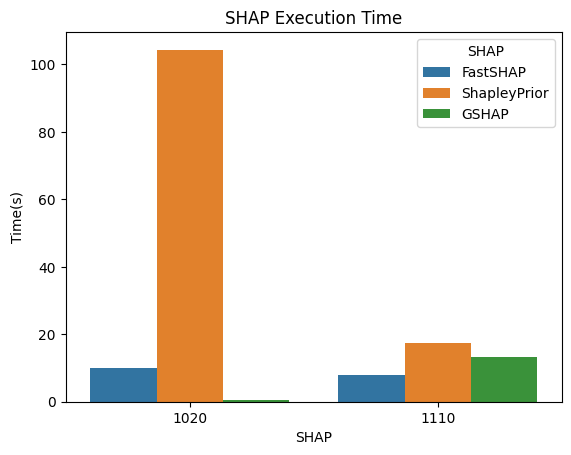

In [81]:
sns.barplot(data=results, x="#Sample", y="Total Time", hue="SHAP")
plt.title("SHAP Execution Time")
plt.xlabel("SHAP")
plt.ylabel("Time(s)")
# plt.savefig("shap_value_execution_time.png")